In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
my_model = models.load_model("saved_models/my_model")

In [10]:
my_model.layers

In [7]:
for layer in my_model.layers:
    if "conv" in layer.name:
        filters, biases = layer.get_weights()
        print(layer.name, filters.shape)

conv2d (3, 3, 3, 16)
conv2d_1 (3, 3, 16, 32)
conv2d_2 (3, 3, 32, 32)
conv2d_3 (3, 3, 32, 32)
conv2d_4 (3, 3, 32, 32)


In [8]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

<function matplotlib.pyplot.show(close=None, block=None)>

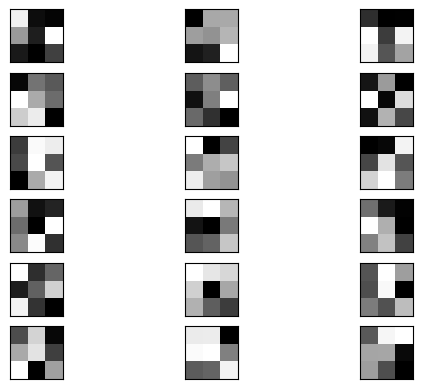

In [9]:
number_of_filters, ix = 6, 1
for i in range(number_of_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(number_of_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(f[:, :, j], cmap = "gray")
        ix += 1
        
plt.show

In [88]:
from tensorflow.keras.models import Model

new_model = Model(inputs = my_model.inputs, outputs = my_model.layers[2].output)

In [89]:
from PIL import Image

img = Image.open("./fruitdataset/Alphonso/Image_1.jpeg") 

In [90]:
import numpy as np

img = img.resize((128, 128))
img = tf.convert_to_tensor(img)
img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
img_array = tf.expand_dims(img_array, 0)

feature_maps = new_model.predict(img_array)

1/1 [==============================] - 0s 49ms/step


In [91]:
feature_maps.shape

(1, 126, 126, 16)

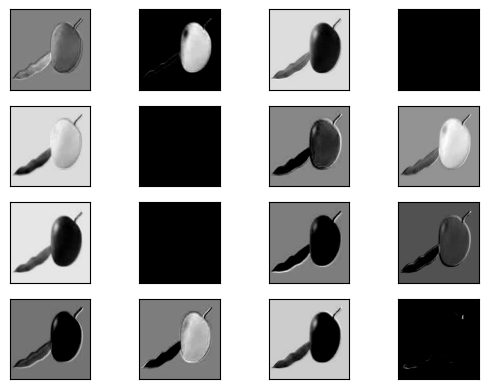

In [104]:
import cv2

square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
#         image = cv2.cvtColor(feature_maps[0, :, :, ix-1], cv2.COLOR_BGR2RGB)
#         plt.imshow(image)
        plt.imshow(feature_maps[0, :, :, ix - 1], cmap = "gray")
        ix += 1

plt.show()